# Reconocimiento de símbolos Devanagari Manuscritos
## Aprendizaje Automático: Proyecto Final

### Patricia Córdoba Hidalgo
### David Cabezas Berrido

### Uso:
- Colocar este cuaderno en la misma carpeta que datos.zip
- Descomprimir datos.zip

In [1]:
# Librerías y paquetes a utilizar

import numpy as np
import matplotlib.pyplot as plt

from preprocessing import preprocessing, polynomial
from random_forest import grafNestimators, grafAlpha
from mlp import grafNneur
from logistic_regression import grafLRAlpha

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

#### Script que lee los datos en formato .png, elimina el marco y los escribe como arrays de numpy (sin marco)

Requiere que los datos estén en la carpeta `datos/DevanagariHandwrittenCharacterDataset`
Lee los nombres de las clases del fichero `datos/characters.txt` (se incluye en datos.zip)
Escribe los datos en `datos/DevanagariGrayscale`

Se proporcionan los datos ya guardados como arrays de numpy, no es necesario ejecutar el script.

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt

# Paths
CHARACTERS='datos/characters.txt'

TRAIN_IMG_DIR='datos/DevanagariHandwrittenCharacterDataset/Train/'
TEST_IMG_DIR='datos/DevanagariHandwrittenCharacterDataset/Test/'

TRAIN_GRAY='datos/DevanagariGrayscale/train.npz'
TEST_GRAY='datos/DevanagariGrayscale/test.npz'
    
# Names of classes
with open(CHARACTERS,'r') as f:
    characters = f.read().split('\n')[:-1]

# Load data from .png format
def loadPng(folder, characters=characters):
    data=[]
    label=[]
    l=0
    for c in characters:
        l+=1 # Classes from 1 to 46
        print('Cargando: '+c)
        path_to_folder=folder+c+'/*.png'
        for img_path in glob.glob(path_to_folder):
            image = plt.imread(img_path)[2:-2,2:-2] # Cut frame
            data.append(image)
            label.append(l)
            
    return np.array(data,np.float32), np.array(label,np.int8)

# Save greyscale vector
def saveGrey(filename, data, label):
    np.savez_compressed(filename, data, label)

print('Cargando datos de entrenamiento')
# Load train data from images
train_mat, train_label = loadPng(TRAIN_IMG_DIR, characters)
# Matrix to vector
train=np.reshape(train_mat,(train_mat.shape[0],784))
# Save train as greyscale
saveGrey(TRAIN_GRAY, train, train_label)
print('Datos de entrenamiento guardados en grayscale')

print('Cargando datos de test')
# Load test data from images
test_mat, test_label = loadPng(TEST_IMG_DIR, characters)
# Matrix to vector       
test=np.reshape(test_mat,(test_mat.shape[0],784))
# Save test as greyscale
saveGrey(TEST_GRAY, test, test_label)
print('Datos de test guardados en grayscale')

### Preprocesado:
Declaración de las funciones que utilizamos para el preprocesado.
Requiere tener instalada la librería *skimage*.
Hemos proporcinado también los datos preprocesados, pero es necesario ejecutar la celda para declarar la función `polynomial`

In [2]:
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.measure import label, regionprops, block_reduce
from skimage.transform import resize

from joblib import Parallel, delayed

# Tuneable parameters
WIDTH=28 # WIDTH to resize
BLOCK_REDUCE=True # Wether or not to perform block reduce

# Center character by crop and resize image
def centerAndResize(img):

    # Ignote low intensity pixels to obtain components
    thresh = threshold_otsu(img)
    bw = closing(img > min(thresh*2,0.95), square(3))
    label_image = label(bw) # Separate into connected regions

    # Compute box that contains all components
    mminr=28; mminc=28; mmaxr=0; mmaxc=0
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        mminr=min(minr,mminr)
        mminc=min(minc,mminc)
        mmaxr=max(maxr,mmaxr)
        mmaxc=max(maxc,mmaxc)

    # Resize to unified size
    return resize(img[mminr:mmaxr,mminc:mmaxc],(WIDTH,WIDTH), anti_aliasing=True)

# Preprocessing for single image
def preprocess(img):
    img = np.reshape(img,(28,28))
    img = centerAndResize(img)
    if BLOCK_REDUCE:
        img = block_reduce(img,(2,2),np.mean)
    img = np.reshape(img,img.shape[0]*img.shape[1])
    return img
    
# Aplay all preprocessing to data
def preprocessing(data):
    out = Parallel(n_jobs=4)(map(delayed(preprocess),data))            
    return np.array(out,np.float32)

# Add some polynomial features to data
def polynomial(data,deg):
    out=data.copy()
    for n in range(2,deg+1):
        out=np.concatenate((out,data**n),axis=1)

    return out

### Generación de gráficas para estimar hiperparámetros

El código a continuación corresponde a las funciones utilizadas para generar gráficas que contrasten una accuracy obtenida por validación cruzada frente a diversos valores de cada hiperparámetro. Hemos ido estrechando el rango hasta obtener un valor adecuado con suficiente precisión.

La ejecución de estas funciones conlleva varias horas, las gráficas que hemos obtenido están en la memoria.

In [ ]:
# Hiperparámetros para Random Forest

# Random Forest Parameters:
RF_N_ESTIMATORS= 287 # Number of estimators for baggin
FIRST_N = 285 #275 #200 #50
LAST_N = 295 #300
INC_N = 2 #5 #25 #50

RF_ALPHA = 0 # Cost-Complexity Parameter
FIRST_A = 0
LAST_A = 0.00001 # 0.00005 #0.0001
NUM_A = 6 #11 #6

# Compares accuracy of different numbers of estimators
def grafNestimators(data, label):
    output=[]
    for n in range(FIRST_N, LAST_N + 1, INC_N):
        print(n)
        rf=RandomForestClassifier(n_estimators=n, n_jobs=4)
        score=np.mean(cross_val_score(rf,data,label,cv=3))
        output.append(score)
        print(output[-1])
    plt.plot(range(FIRST_N,LAST_N + 1,INC_N),output, c='g')
    plt.title('Accuracy media frente a nº de estimadores')
    plt.xlabel('Nº de estimadores')
    plt.ylabel('Accuracy')

    plt.show()
    
# Compares accuracy of different values of alpha
def grafAlpha(data, label):
    output=[]
    for a in np.linspace(FIRST_A, LAST_A, NUM_A):
        print(a)
        rf=RandomForestClassifier(n_estimators=RF_N_ESTIMATORS, ccp_alpha=a, n_jobs=4)
        output.append(np.mean(cross_val_score(rf,data,label,cv=3)))

    print(output)

    plt.plot(np.linspace(FIRST_A,LAST_A,NUM_A),output, c='g')
    plt.title('Accuracy media frente a alpha')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
# Hiperparámetros para Perceptrón Multicapa

# MLP Parameters:
N_NEUR= 59 # Number of neurons in hidden layers
FIRST = 58 #55 # 50
LAST = 62 #70 # 100
INC = 1 #5 # 10

# Compares accuracy of different numbers of neurons
def grafNneur(data, label):
    output=[]
    for n in range(FIRST, LAST + 1, INC):
        print(n)
        mlp=MLPClassifier(hidden_layer_sizes= (N_NEUR, N_NEUR), activation='tanh', max_iter = 800)
        score=np.mean(cross_val_score(mlp,data,label,cv=2))
        output.append(score)
        print(output[-1])
    plt.plot(range(FIRST,LAST + 1,INC),output, c='b')
    plt.title('Accuracy media frente a nº de neuronas')
    plt.xlabel('Nº de neuronas')
    plt.ylabel('Accuracy')

    plt.show()

In [ ]:
# Hiperparámetros para Regresión Logística

# Logistic Regression Parameters:
ALPHA = 4e-5 # Alpha for regularization
FIRST = 0.000025 #0.00002 #1e-5 #5e-5
LAST = 0.000045 #0.00007 #0.000353 #0.005
NUM = 5 #6 #10 #11

# Compares accuracy of different values of alpha
def grafLRAlpha(data, label):
    output=[]
    for a in np.linspace(FIRST, LAST, NUM):
        print(a)
        lr=SGDClassifier(loss='log', alpha=a,n_jobs=4,max_iter=2000)
        score=np.mean(cross_val_score(lr,data,label,cv=3))
        output.append(score)
        print(output[-1])
    plt.plot(np.linspace(FIRST,LAST, NUM),output, c='r')
    plt.title('Accuracy media frente a alpha (LR)')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')

    plt.show()

#### Hiperparámetros seleccionados

In [3]:
# Random Forest:
RF_N_ESTIMATORS=287 # Number of estimators for baggin
RF_ALPHA=0 # Cost-Complexity Parameter

# Multi-Layer Perceptron:
MLP_NNEURS=59

# Logistic Regression
LR_ALPHA=4e-5

### Carga de los datos

In [4]:
# Función para cargar los datos

# Load greyscale vector
def loadGrey(filename):
    X=np.load(filename)
    data = X['arr_0']
    label= X['arr_1']
    X.close()
    return data, label

In [5]:
# Cargar datos preprocesados

TRAIN_PRE='datos/DevanagariPreprocessed/train.npz'
TEST_PRE='datos/DevanagariPreprocessed/test.npz'

train, train_label = loadGrey(TRAIN_PRE)
test, test_label = loadGrey(TEST_PRE)

print('Número de características:', train.shape[1])

Número de características: 196


In [6]:
# Cargar y preprocesar datos

TRAIN_GRAY='datos/DevanagariGrayscale/train.npz'
TEST_GRAY='datos/DevanagariGrayscale/test.npz'

train, train_label = loadGrey(TRAIN_GRAY)
test, test_label = loadGrey(TEST_GRAY)

print('Número de características:',train.shape[1])
print('Preprocesando datos')
train = preprocessing(train)
test = preprocessing(test)

print('Número de características:',train.shape[1])

Número de características: 784
Preprocesando datos
Número de características: 196


In [7]:
# Comprobamos que no hay características con varianza 0
# Todas aportan algo de información

print('Características tras preprocesado:', train.shape[1])
varthresh = VarianceThreshold()
train=varthresh.fit_transform(train)
print('Características tras eliminar las de varianza nula:', train.shape[1])

Características tras preprocesado: 196
Características tras eliminar las de varianza nula: 196


In [8]:
# Añadimos nuevas características para el modelo lineal

# New polynomial features for lineal model
trainLin=polynomial(train,4) # Potencias 2, 3 y 4 de los datos
stdScaler=StandardScaler().fit(trainLin) # En la documentación de sklearn se recomienda que los datos para SGD tengan media 0 y varianza 1
trainLin=stdScaler.transform(trainLin)
testLin=polynomial(test,4)
testLin=stdScaler.transform(testLin)
print('Características para el modelo lineal:', trainLin.shape[1])

Características para el modelo lineal: 784


### Proyección 2D de los datos

En la memoria, incluimos proyecciones en 2D de los datos antes y después del preprocesamiento.
Este es el código con el que hemos generado las gráficas.
No es necesario ejecutarlo, tarda unos minutos y las proyecciones ya están en la memoria.

In [9]:
# Funciones para proyectar y visualizar los datos

# 2D data visualization
def plot2D(x,y, alg_name,classes):
    plt.scatter(x[:,0],x[:,1],c=y, cmap='tab20', alpha=0.5)
    plt.title('Representación de los '+classes+' en dos dimensiones\n usando el algoritmo '+alg_name)
    plt.show()

# 2D projection and visualization of data
def visualize2D(x,y,classes=''):
    x2=PCA(n_components=2).fit_transform(x) # PCA projection
    plot2D(x2,y,'PCA',classes)
    x2=TSNE(n_components=2,init=x2).fit_transform(x) # TSNE projection
    plot2D(x2,y,'TSNE',classes)

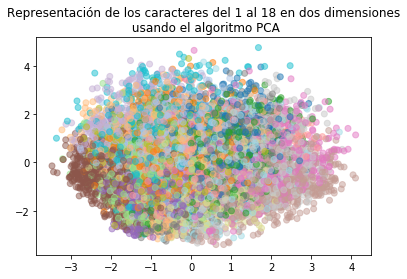

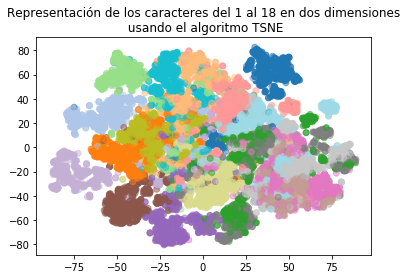

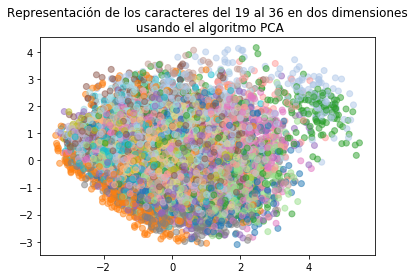

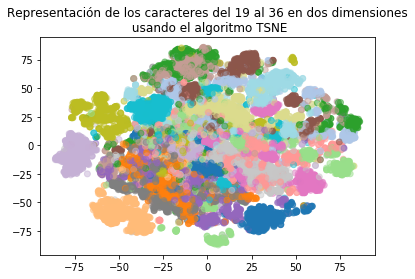

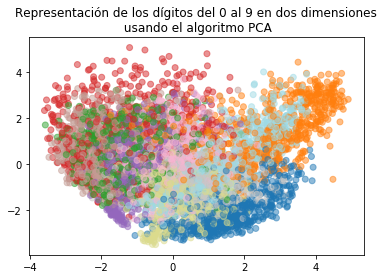

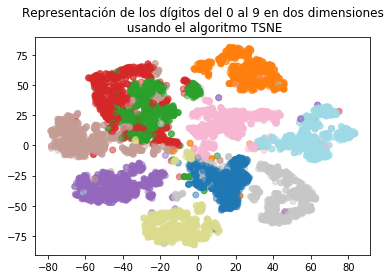

In [10]:
# Código para generar las proyecciones

# Hay demasiados datos, sólo representamos una porción
x, x1, y, y1 = train_test_split(train, train_label,stratify=train_label, train_size=0.4)

# Hay demasiadas clases, las repartimos en tres representaciones
x2=[x[i] for i in range(len(x)) if 1<=y[i]<=18] # Classes to plot
y2=[y[i] for i in range(len(y)) if 1<=y[i]<=18]
visualize2D(x2,y2,'caracteres del 1 al 18')

x2=[x[i] for i in range(len(x)) if 19<=y[i]<=36] # Classes to plot
y2=[y[i] for i in range(len(y)) if 19<=y[i]<=36]
visualize2D(x2,y2,'caracteres del 19 al 36')

x2=[x[i] for i in range(len(x)) if 37<=y[i]<=46] # Classes to plot
y2=[y[i] for i in range(len(y)) if 37<=y[i]<=46]
visualize2D(x2,y2,'dígitos del 0 al 9')

### Modelos a comparar
Contrastamos el modelo lineal de Regresión Logística con los modelos no lineales Random Forest y Perceptrón Multicapa

In [11]:
# Models
rf=RandomForestClassifier(n_estimators=RF_N_ESTIMATORS, ccp_alpha=RF_ALPHA, n_jobs=4) # Random Forest
mlp=MLPClassifier(hidden_layer_sizes=(MLP_NNEURS,MLP_NNEURS),activation='tanh',max_iter=800,early_stopping=True) # MLP
lr=SGDClassifier(loss='log', alpha=LR_ALPHA, n_jobs=4, max_iter=2000) # Logistic Regression

### Scores de validación

Los hemos utilizado para contrastar decisiones a la hora del preprocesamiento y para decidir si era adecuado utilizar *early stopping* para el Perceptrón Multicapa

In [12]:
# Separación de un conjunto de validación

# Split validation set from train data
tra, val, tra_label, val_label = train_test_split(train, train_label, stratify=train_label, train_size=0.8, test_size=0.2)

# New polynomial features for lineal model
traLin=polynomial(tra,4) # Potencias 2, 3 y 4 de los datos
stdScaler=StandardScaler().fit(traLin) # En la documentación de sklearn se recomienda que los datos para SGD tengan media 0 y varianza 1
traLin=stdScaler.transform(traLin)
valLin=polynomial(val,4)
valLin=stdScaler.transform(valLin)

In [13]:
# Accuracy para Random Forest

print('\nRandom Forest:')
rf.fit(tra, tra_label)
print('Train Accuracy:',rf.score(tra,tra_label))
print('Validation Accuracy:', rf.score(val,val_label))


Random Forest:
Train Accuracy: 1.0
Validation Accuracy: 0.9161125319693094


In [14]:
# Accuracy para Perceptrón Multicapa

print('\nMulti-Layer Perceptron (MLP):')
mlp.fit(tra,tra_label)
print('Train Accuracy:',mlp.score(tra,tra_label))
print('Validation Accuracy:', mlp.score(val,val_label))


Multi-Layer Perceptron (MLP):
Train Accuracy: 0.9564737851662404
Validation Accuracy: 0.87653452685422


In [17]:
# Accuracy para Regresión Logística (tarda varios minutos)

print('\nRegresión Logística:')
lr.fit(traLin,tra_label)
print('Train Accuracy:',lr.score(traLin,tra_label))
print('Validation Accuracy:', lr.score(valLin,val_label))


Regresión Logística:
Train Accuracy: 0.7454283887468031
Validation Accuracy: 0.7228260869565217


### Desempeño final

In [18]:
# Entrenamos los modelos usando la totalidad de los datos de train

rf.fit(train,train_label)
mlp.fit(train,train_label)
lr.fit(trainLin,train_label) # Este tarda varios minutos

SGDClassifier(alpha=4e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=2000,
              n_iter_no_change=5, n_jobs=4, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
# Función para visualizar matrices de confusión

# Matrix visualization
def visualizeMatrix(m, title='', conf=False):
    plt.matshow(m, cmap='viridis')
    plt.colorbar()
    plt.title(title,pad=20.0)
    if conf:
        plt.ylabel('Verdaderos')
        plt.xlabel('Predicciones')
    plt.show()

#### Predicciones sobre el conjunto de train (E_in)

Accuracy de Random Forest sobre Train: 1.0


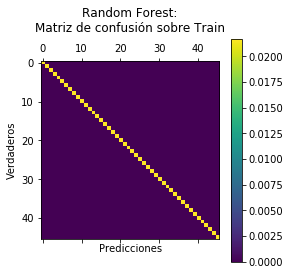

In [20]:
# Random Forest

pred = rf.predict(train)
acc = accuracy_score(train_label,pred)
conf_mat = confusion_matrix(train_label,pred,normalize='all')

print('Accuracy de Random Forest sobre Train:',acc)
visualizeMatrix(conf_mat,'Random Forest:\nMatriz de confusión sobre Train',True)

Accuracy de MLP sobre Train: 0.9388874680306906


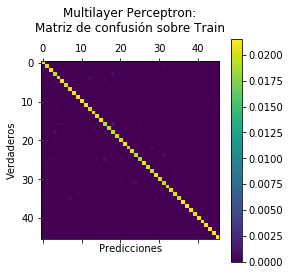

In [21]:
# MLP

pred = mlp.predict(train)
acc = accuracy_score(train_label,pred)
conf_mat = confusion_matrix(train_label,pred,normalize='all')

print('Accuracy de MLP sobre Train:',acc)
visualizeMatrix(conf_mat,'Multilayer Perceptron:\nMatriz de confusión sobre Train',True)

Accuracy de Regresión Logística sobre Train: 0.74423273657289


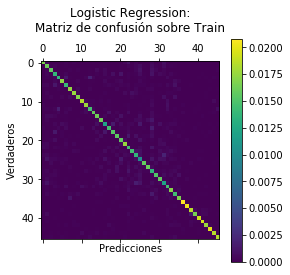

In [22]:
# Logistic Regression

pred = lr.predict(trainLin)
acc = accuracy_score(train_label,pred)
conf_mat = confusion_matrix(train_label,pred,normalize='all')

print('Accuracy de Regresión Logística sobre Train:',acc)
visualizeMatrix(conf_mat,'Logistic Regression:\nMatriz de confusión sobre Train',True)

#### Predicciones sobre el conjunto de test

Accuracy de Random Forest sobre Test: 0.9241304347826087


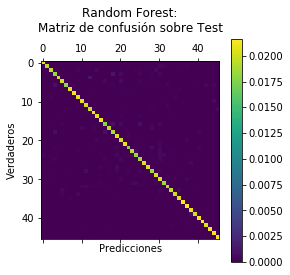

In [23]:
# Random Forest

pred = rf.predict(test)
acc = accuracy_score(test_label,pred)
conf_mat = confusion_matrix(test_label,pred,normalize='all')

print('Accuracy de Random Forest sobre Test:',acc)
visualizeMatrix(conf_mat,'Random Forest:\nMatriz de confusión sobre Test',True)

Accuracy de MLP sobre Test: 0.8973188405797101


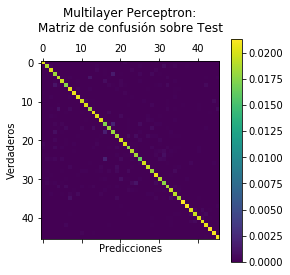

In [24]:
# MLP

pred = mlp.predict(test)
acc = accuracy_score(test_label,pred)
conf_mat = confusion_matrix(test_label,pred,normalize='all')

print('Accuracy de MLP sobre Test:',acc)
visualizeMatrix(conf_mat,'Multilayer Perceptron:\nMatriz de confusión sobre Test',True)

Accuracy de Regresión Logística sobre Test: 0.735072463768116


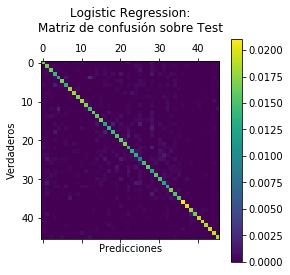

In [25]:
# Logistic Regression

pred = lr.predict(testLin)
acc = accuracy_score(test_label,pred)
conf_mat = confusion_matrix(test_label,pred,normalize='all')

print('Accuracy de Regresión Logística sobre Test:',acc)
visualizeMatrix(conf_mat,'Logistic Regression:\nMatriz de confusión sobre Test',True)